### Example code for computing CIV distance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import richardsplot as rplot
from sklearn.preprocessing import scale

from CIVfunctions import project, CIV_distance

/Users/trevormccaffrey/anaconda3/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


---

#### Basic implementation

Load in example file with CIV EW+Blueshift already computed.

In [2]:
dat = pd.read_csv("data/LOFAR_from8403colorselected_all388_CIV.csv")
dat.iloc[:,10:].head()

,SDSS_NAME_1a,RA_1a,DEC_1a,REDSHIFT,PLATE_1a,FIBER_1a,MJD_1a,TARGET_FLAG_TARGET,NSPECOBS,UNIFORM_TARGET,...,Separation_2,CIV_blue,CIV_EW,good,z_paul,SDSS_NAME_2,Separation_Amy,CIV_DIST_021721,Separation,CIV_DIST_041921
0,104446.00+521742.8,161.191681,52.295242,1.7513,1010,182,52649,3,1,1,...,0.015827,87.889379,37.666121,True,1.75054,104446.00+521742.8,0.015827,2.522933,0.002494,2.124091
1,104547.58+551853.8,161.448257,55.314972,1.8896,906,462,52368,1048578,1,1,...,0.008950,142.521789,44.743671,True,1.88758,104547.58+551853.8,0.008950,2.422896,0.003449,1.985659
2,104718.64+541917.8,161.827698,54.321629,1.8288,906,55,52368,3145739,1,1,...,0.013102,832.307354,49.698713,True,1.83249,104718.64+541917.8,0.013102,2.791469,0.005172,2.129244
3,104829.97+550819.0,162.124893,55.138630,2.0671,906,518,52368,1048578,1,1,...,0.012861,1798.550056,22.573777,True,2.07342,104829.97+550819.0,0.012861,3.848747,0.003931,3.199583
4,104852.00+530747.2,162.216675,53.129780,1.6792,1010,509,52649,1048578,1,1,...,0.007413,872.211364,51.004578,True,1.68111,104852.00+530747.2,0.007413,2.801772,0.002967,2.110882


In [3]:
ew   = dat["CIV_EW"].values
logEW= np.log10(ew)
blue = dat["CIV_blue"].values

bestfit = np.load("data/bestfit.npy")

In [4]:
!ls data

LOFAR_from8403colorselected_all388_CIV.csv
LOFAR_from8403colorselected_detections123_1arcsec.csv
RM_CIV_bestFitLine_noScale.npy
bestfit.npy


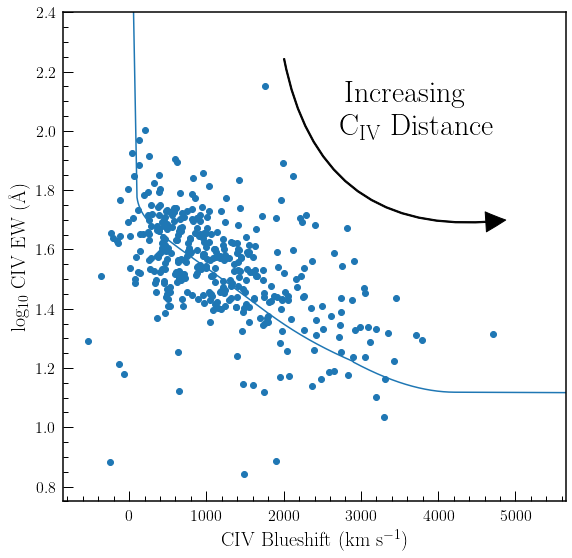

In [5]:
fig = plt.figure(figsize=(9,9))

#Visualize increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((2000, 2.25), (4900, 1.7),
                             connectionstyle="arc3,rad=.47", **kw)
plt.gca().add_patch(a1)
plt.text(x=2800,y=2.1,s="Increasing", fontsize=30, weight='extra bold')
plt.text(x=2735,y=1.985,s="C$_\mathrm{IV}$ Distance", fontsize=30)

plt.plot(bestfit[:,0], bestfit[:,1])
plt.scatter(blue, logEW)
plt.xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=20)
plt.ylabel("log$_{10}$ CIV EW (Å)", fontsize=20)
plt.xlim(-850,5650)
plt.ylim(0.75,2.4)

plt.show()

Note: points with EW $\gtrsim105$ Angstroms will be projected onto the top of the curve.

In [6]:
from time import time

start = time()
data = np.array([blue, logEW]).T
dist = CIV_distance(data, bestfit) #compute CIV distances like this
end = time()

---

#### Save time with the ``step`` parameter

``CIV_distance()`` function has an optional "step" parameter.  How it's normally set up is to project each data point onto the best-fit curve, then travel along the best-fit line--point-by-point--checking when you've passed a point on the line.  The default argument ``step=1`` will check every point along the curve, ``step=100`` will check every hundredth point etc.  Since the curve is so dense, you can often get away with a much higher step size than 1, increasing your runtime dramatically; for example, ``step=100`` will result in 100 times less iterations of the for loop inside ``CIV_distance()``.

Visualize accuracy as a function of step size.  Will consider "correct" to be the distances corresponding to ``step=1``.

In [7]:
bestfit.shape

(52920, 2)

In [8]:
step_list = np.logspace(np.log10(1), np.log10(1000), 10).astype(int)
diff_list = [0]
dt_list   = [end - start]

In [9]:
for step_size in step_list[1:]:
    start_time = time()
    idist = CIV_distance(data, bestfit, step=step_size)
    diff_list.append(np.median(np.abs((dist-idist)/dist)))
    end_time = time()
    dt_list.append(end_time - start_time)

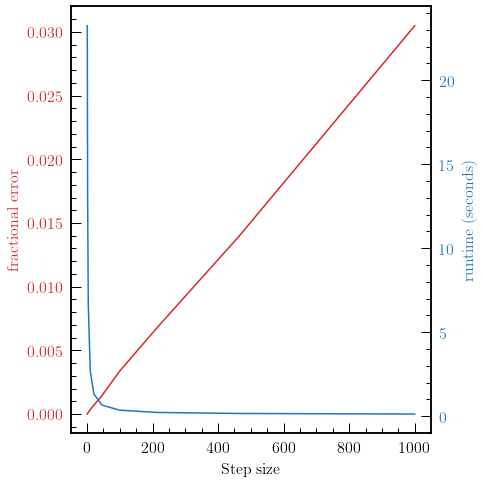

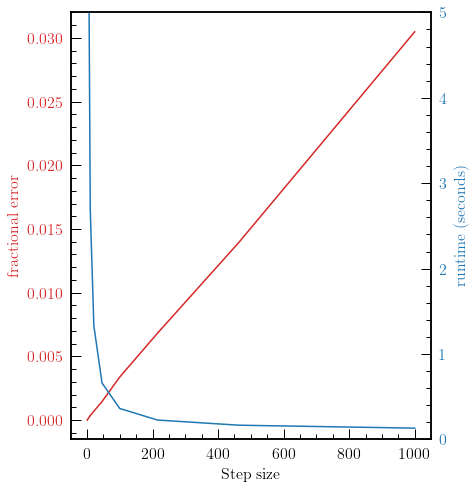

In [10]:
fig, ax1 = plt.subplots(figsize=(7,7))

color = 'tab:red'
ax1.set_xlabel('Step size')
ax1.set_ylabel('fractional error', color=color)
ax1.plot(step_list, diff_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('runtime (seconds)', color=color)  # we already handled the x-label with ax1
ax2.plot(step_list, dt_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

fig, ax11 = plt.subplots(figsize=(7,7))

color = 'tab:red'
ax11.set_xlabel('Step size')
ax11.set_ylabel('fractional error', color=color)
ax11.plot(step_list, diff_list, color=color)
ax11.tick_params(axis='y', labelcolor=color)

ax22 = ax11.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax22.set_ylabel('runtime (seconds)', color=color)  # we already handled the x-label with ax1
ax22.plot(step_list, dt_list, color=color)
ax22.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax22.set_ylim(0,5)
plt.show()

Plot showing both the time saved and median error in C IV distance as a function of step size.  Lesson learned: use a non-unity step size for lots of data! Roughly ``step=50`` looks like a good choice.  **Use the step parameter when testing big datasets.**

----

make plots

In [11]:
proj = project(data, bestfit)

In [12]:
import joblib
scaler = joblib.load("scalers/scaler_logEW.save")
data_scale = scaler.transform(data)
bestfit_scale = scaler.transform(bestfit)

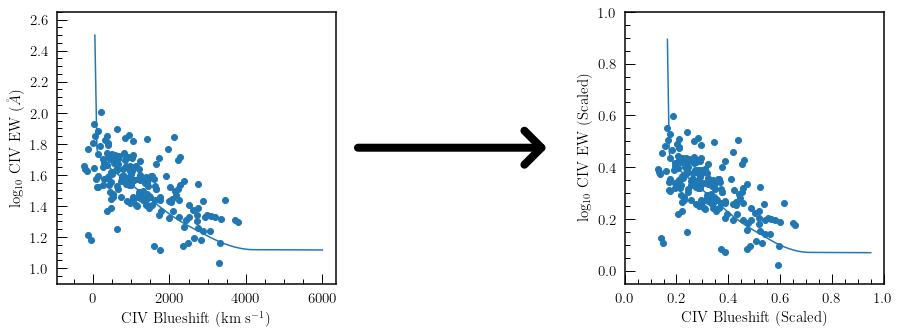

In [13]:
from matplotlib.patches import ConnectionPatch

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(15,5))
plt.subplots_adjust(wspace=1.0)

ax1.plot(bestfit[:,0], bestfit[:,1])
ax1.scatter(data[::2,0], data[::2,1])
ax1.set_xlim(-950,6350)
ax1.set_ylim(0.9,2.65)
ax1.set_xlabel("CIV Blueshift (km s$^{-1}$)", fontsize=15)
ax1.set_ylabel("log$_{10}$ CIV EW ($Å$)", fontsize=15)
ax1.tick_params(axis='both', which="both", labelsize=15)

con1 = ConnectionPatch(
    xyA=(1.08,0.5), coordsA=ax1.transAxes,
    xyB=(-0.30, 0.5), coordsB=ax2.transAxes,
    arrowstyle="->, head_width=1.7, head_length=1.7", color="black", linewidth=8.0)
fig.add_artist(con1)

ax2.plot(bestfit_scale[:,0], bestfit_scale[:,1])
ax2.scatter(data_scale[::2,0], data_scale[::2,1])
ax2.set_xlim(0,1)
ax2.set_ylim(-.05,1)
ax2.set_xlabel("CIV Blueshift (Scaled)", fontsize=15)
ax2.set_ylabel("log$_{10}$ CIV EW (Scaled)", fontsize=15)
ax2.tick_params(axis='both', which="both", labelsize=15)
ax2.set_aspect("equal")

plt.savefig("imgs/scale_data.png")
plt.show()

In [14]:
proj_scale = project(data_scale, bestfit_scale)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

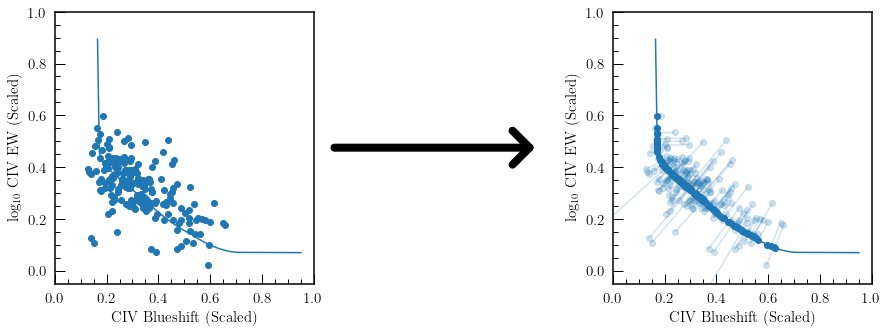

In [15]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(15,5))
plt.subplots_adjust(wspace=1.0)

con1 = ConnectionPatch(
    xyA=(1.08,0.5), coordsA=ax1.transAxes,
    xyB=(-0.30, 0.5), coordsB=ax2.transAxes,
    arrowstyle="->, head_width=1.7, head_length=1.7", color="black", linewidth=8.0)
fig.add_artist(con1)

ax1.plot(bestfit_scale[:,0], bestfit_scale[:,1])
ax1.scatter(data_scale[::2,0], data_scale[::2,1])
ax1.set_xlim(0,1)
ax1.set_ylim(-.05,1)
ax1.set_xlabel("CIV Blueshift (Scaled)", fontsize=15)
ax1.set_ylabel("log$_{10}$ CIV EW (Scaled)", fontsize=15)
ax1.tick_params(axis='both', which="both", labelsize=15)
ax1.set_aspect("equal")

ax2.scatter(data_scale[::2,0], data_scale[::2,1], alpha=0.2, color=colors[0])
ax2.scatter(proj_scale[::2,0], proj_scale[::2,1], color=colors[0])
ax2.plot(bestfit_scale[:,0], bestfit_scale[:,1], color=colors[0])

for i in range(len(proj_scale[::2,0])):
    ax2.plot([data_scale[::2,0][i], proj_scale[::2,0][i]], [data_scale[::2,1][i], proj_scale[::2,1][i]], alpha=0.2, color=colors[0])

ax2.set_xlim(0,1)
ax2.set_ylim(-.05,1)
ax2.set_xlabel("CIV Blueshift (Scaled)", fontsize=15)
ax2.set_ylabel("log$_{10}$ CIV EW (Scaled)", fontsize=15)
ax2.tick_params(axis='both', which="both", labelsize=15)
ax2.set_aspect("equal")

xticks_scaled = ax2.get_xticks()
yticks_scaled = ax2.get_yticks()

plt.savefig("imgs/project_scaled.png")
plt.show()

Example plot of CIV distance increments.

In [17]:
dist_line = CIV_distance(bestfit, bestfit, step=20)

In [18]:
bestfit_scale[np.argmin(abs(dist_line-1.2)),:]

array([0.79195056, 0.07020304])

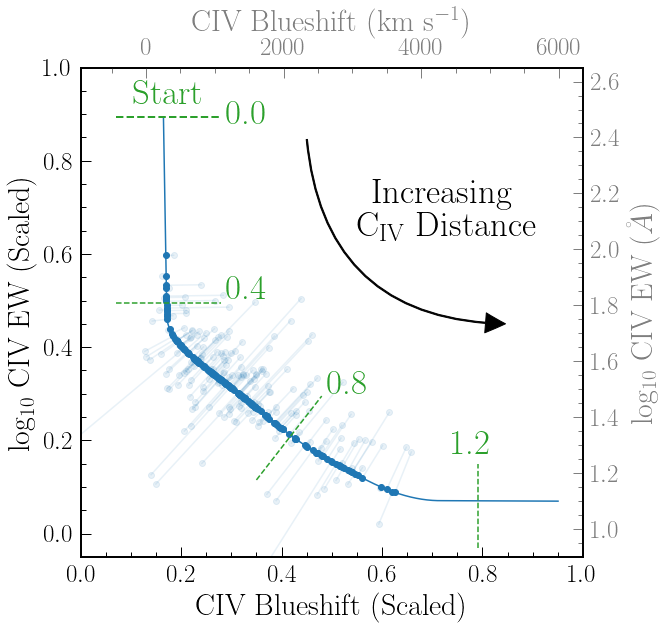

In [19]:
fig, ax1 = plt.subplots(figsize=(9,9))

ax1.scatter(proj_scale[::2,0], proj_scale[::2,1], color=colors[0])
ax1.plot(bestfit_scale[:,0], bestfit_scale[:,1], color=colors[0])

ax1.scatter(data_scale[::2,0], data_scale[::2,1], alpha=0.1, color=colors[0])
for i in range(len(proj_scale[::2,0])):
    ax1.plot([data_scale[::2,0][i], proj_scale[::2,0][i]], [data_scale[::2,1][i], proj_scale[::2,1][i]], alpha=0.1, color=colors[0])



ax1.plot([0.07, 0.28], [0.895, 0.895], linestyle="--", linewidth=2, color=colors[2])
ax1.text(0.29, 0.88, "0.0", fontsize=35, color=colors[2])
ax1.text(0.105, 0.922, "Start", fontsize=35, color=colors[2], family="monospace") #Add starting line

#ax1.plot([0.07, 0.28], [0.694, 0.694], linewidth=2, linestyle="--", color=colors[2])
#ax1.text(0.29, 0.674, "0.2", fontsize=30, color=colors[2])

ax1.plot([0.07, 0.28], [0.494, 0.494], linestyle="--", color=colors[2])
ax1.text(0.29, 0.504, "0.4", fontsize=35, color=colors[2])

#ax1.plot([0.2, 0.35], [0.245, 0.425], linestyle="--", color=colors[2])
#ax1.text(0.36, 0.415, "0.6", fontsize=30, color=colors[2])

ax1.plot([0.35, 0.48], [0.115, 0.295], linestyle="--", color=colors[2])
ax1.text(0.49, 0.30, "0.8", fontsize=35, color=colors[2])

#ax1.plot([0.55, 0.65], [0.01, 0.19], linestyle="--", color=colors[2])
#ax1.text(0.62, 0.215, "1.0", fontsize=30, color=colors[2])

ax1.plot([0.792, 0.792], [-0.03, 0.15], linestyle="--", color=colors[2])
ax1.text(0.74, 0.17, "1.2", fontsize=35, color=colors[2])



#Arrow goes out of frame without this for some reason?
ax1.set_xlim(0,1)
ax1.set_ylim(-.05,1)
color = "k"
#Visualize increasing CIV distance
style = "Simple, tail_width=1.25, head_width=20, head_length=20"
kw = dict(arrowstyle=style, color="k")
a1 = patches.FancyArrowPatch((0.45, 0.85), (0.85, 0.45),
                             connectionstyle="arc3,rad=.45", **kw)
plt.gca().add_patch(a1)
plt.text(x=0.58,y=0.71,s="Increasing", fontsize=35, weight='extra bold')
plt.text(x=0.55,y=0.64,s="C$_\mathrm{IV}$ Distance", fontsize=35, weight='extra bold')

#ax1.title("CIV Distance Path", fontsize=20)
ax1.set_xlabel("CIV Blueshift (Scaled)", fontsize=30, color=color)
ax1.set_ylabel("log$_{10}$ CIV EW (Scaled)", fontsize=30, color=color)
ax1.tick_params(axis='both', which="both", color=color, labelcolor=color, labelsize=25)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = colors[7]
ax2.set_ylabel('log$_{10}$ CIV EW ($Å$)', color=color, fontsize=30)  
#ax2.plot(bestfit_scale[:,0], bestfit_scale[:,1], alpha=1.0, color=color)
ax2.tick_params(axis='y', which="both", color=color, labelcolor=color, labelsize=25)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
#ax2.set_xlim(-950,6350)
ax2.set_ylim(0.9,2.65)

ax22 = ax1.twiny()  # instantiate a second axes that shares the same y-axis
ax22.set_xlabel('CIV Blueshift (km s$^{-1}$)', color=color, fontsize=30)
#ax22.plot(bestfit[:,0], bestfit[:,1], alpha=0.5, color=color)
ax22.tick_params(axis='x', which="both", color=color, labelcolor=color, labelsize=25)
ax22.xaxis.set_label_position('top')
ax22.xaxis.tick_top()
ax22.set_xlim(-950,6350)
#ax22.set_ylim(0.9,2.65)

plt.savefig("imgs/distance_path.png")
plt.show()